In [2]:
!pip install shapely

You should consider upgrading via the '/home/amor/Documents/code_dw/neural-styles/venv/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import pydiffvg

path1 = "/home/amor/Documents/code_dw/neural-styles/deps/LIVE-Layerwise-Image-Vectorization/LIVE/log/166074017552_robot_love/output-svg/4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4.svg"

path2 = "/home/amor/Documents/code_dw/neural-styles/deps/LIVE-Layerwise-Image-Vectorization/LIVE/log/166022352692_neural_style_test_128_2/output-svg/4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4.svg"

path3 = "/home/amor/Documents/code_dw/neural-styles/result_filled_n_paths200_im_size224_n_steps500_layer_nameVGG16Layers.Conv5_2_layer_index99.svg"

svg = path3
canvas_width, canvas_height, shapes, shape_groups = \
    pydiffvg.svg_to_scene(svg)

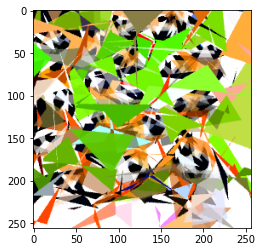

In [2]:
import torch
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from skimage.color import rgb2hsv, hsv2rgb, rgb2lab, lab2rgb
import numpy as np



def my_render(shapes, shape_groups, ax=None, size=(256, 256)):
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene( \
        1 * size[0], 1 * size[1], shapes, shape_groups)
    img = render(1 * size[0], 1 * size[1], 2, 2, 0,
                 torch.ones((1 * size[1], 1 * size[0], 4)), *scene_args)
    if ax is None:
        plt.imshow(img.cpu().detach().numpy())
    else:
        ax.imshow(img.cpu().detach().numpy())

my_render(shapes, shape_groups)

-243.00109417062797


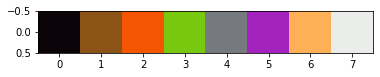

In [5]:
from shapely.geometry import Point, Polygon 

polys = [Polygon(s.points) for s in shapes]


X = [rgb2lab(sg.fill_color.detach().numpy()[:3] * sg.fill_color.detach().numpy()[3]) for sg in shape_groups]
W = [poly.area for poly in polys]


kmeans = KMeans(n_clusters=8, random_state=0, max_iter=1000)
kmeans.fit(X, sample_weight=W)
predicted_kmeans = kmeans.predict(X, sample_weight=W)
print(kmeans.score(X, sample_weight=W) / np.sum(W))

def display_colors(X):
    n_centers, _ = X.shape
    rgb_X = sorted([lab2rgb(X[i, :]) for i in range(n_centers)], key=lambda x: np.sum(x))
    XX = np.concatenate(rgb_X, axis=-1).reshape(-1, 3)
    plt.imshow(XX.reshape(1, -1, 3))
    
display_colors(kmeans.cluster_centers_)

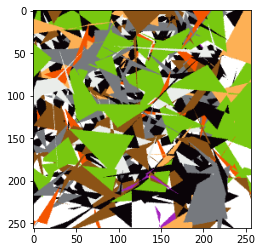

In [6]:


new_colors = [lab2rgb(kmeans.cluster_centers_[i]) for i in predicted_kmeans]

new_sgs = [pydiffvg.ShapeGroup(shape_ids=torch.tensor([i]), fill_color=torch.tensor((*new_colors[i], 1)),
                               ) 
           for i, sg in enumerate(shape_groups)]

my_render(shapes, new_sgs)

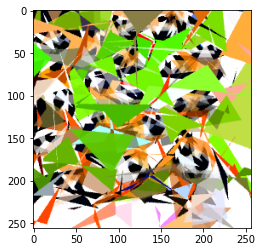

In [7]:
my_render(shapes, shape_groups)


In [8]:
import random

def ransac_kmeans(X, W=None, n_clusters=4, trials=50):
    results = list()
    if W is None:
        W = [1 for w in range(len(X))]
    W_normalized = [w / np.sum(W) for w in W]
        
    
    for i in range(trials):
        n_pts = len(X)
        n_sampled = random.randint(int(6 * n_pts / 7), n_pts)
        indices = np.random.choice(range(n_pts), n_sampled, replace=False, p=W_normalized)
        X_sampled = [X[i] for i in indices]
        W_sampled = [W[i] for i in indices]
        
        ckmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=1000)
        ckmeans.fit(X_sampled, sample_weight=W_sampled)
        results.append((ckmeans, ckmeans.score(X_sampled, sample_weight=W_sampled) / np.sum(W_sampled), n_sampled))
    
    # The score is the negative of the sum of distance to each center
    best_res = sorted(results, key=lambda x: x[1], reverse=True)[0]
    print("Best score : ", best_res[1], " ", best_res[2])
    predicted_kmeans = best_res[0].predict(X, sample_weight=W)
    return best_res[0], predicted_kmeans

    

200 200
Best score :  -136.5515803580897   176
-147.11603943878936


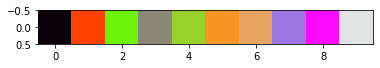

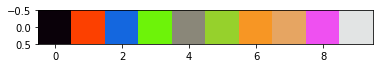

In [9]:

polys = [Polygon(s.points) for s in shapes]
X = [rgb2lab(sg.fill_color.detach().numpy()[:3] * sg.fill_color.detach().numpy()[3] + (0.8 * np.array([1.0, 1.0, 1.0]) * (1.0 - sg.fill_color.numpy()[3]))) 
     for sg in shape_groups]
W = [poly.area for poly in polys]

n_colors = 10

print(len(X), len(W))

r_kmeans, r_predicted_kmeans = ransac_kmeans(X, W, n_colors)
display_colors(r_kmeans.cluster_centers_)


r_new_colors = [lab2rgb(r_kmeans.cluster_centers_[i]) for i in r_predicted_kmeans]
r_new_sgs = [pydiffvg.ShapeGroup(shape_ids=torch.tensor([i]), 
                                 fill_color=torch.tensor((*r_new_colors[i], 1)),
                               ) 
           for i, sg in enumerate(shape_groups)]

kmeans = KMeans(n_clusters=n_colors, random_state=0, max_iter=1000)
kmeans.fit(X, sample_weight=W)
predicted_kmeans = kmeans.predict(X, sample_weight=W)
print(kmeans.score(X, sample_weight=W) / np.sum(W))



    
plt.figure()
display_colors(kmeans.cluster_centers_)



new_colors = [lab2rgb(kmeans.cluster_centers_[i]) for i in predicted_kmeans]
new_sgs = [pydiffvg.ShapeGroup(shape_ids=torch.tensor([i]), fill_color=torch.tensor((*new_colors[i], 1)),
                               ) 
           for i, sg in enumerate(shape_groups)]




Text(0.5, 1.0, 'Ransac sampling')

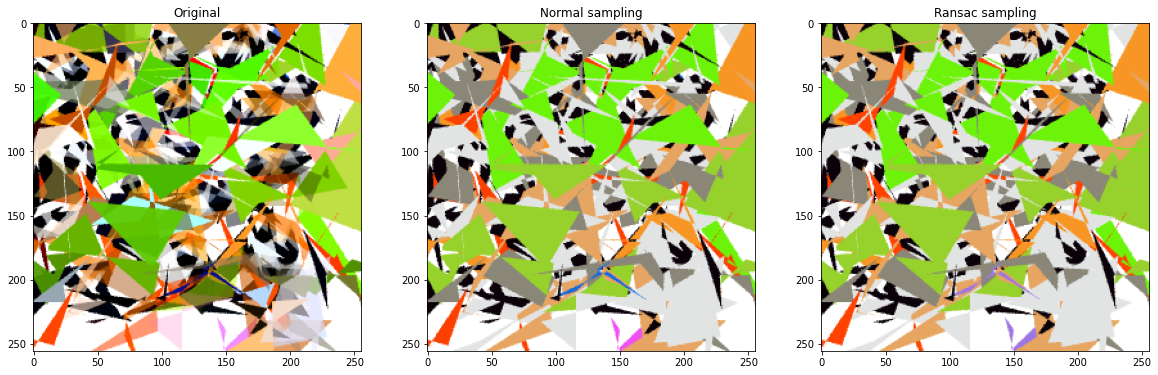

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 20))

my_render(shapes, shape_groups, axes[0])
axes[0].set_title("Original")
my_render(shapes, new_sgs, axes[1])
axes[1].set_title("Normal sampling")
my_render(shapes, r_new_sgs, axes[2])
axes[2].set_title("Ransac sampling")

In [11]:
## Stroke quantization

In [12]:
color_indices = [[i for i in range(len(predicted_kmeans)) if predicted_kmeans[i] == k] for k in range(4)]


In [13]:
color_stroke_width = list()

for color_index in color_indices:
    X_sampled = np.array([float(W[i]) for i in color_index]).reshape((-1, 1))
    fake_W = np.ones_like(X_sampled).reshape(-1)
    stroke_kmeans, _ = ransac_kmeans(X_sampled, fake_W, 1)
    color_stroke_width.append(stroke_kmeans.cluster_centers_[0])
    
color_stroke_width

Best score :  -754058.3675436663   44
Best score :  -541579.7444713915   22
Best score :  -850050.8111725901   48
Best score :  -345876.4084851581   9


[array([994.15417576]),
 array([782.51270534]),
 array([912.0767891]),
 array([810.18351765])]

In [14]:
predicted_kmeans = stroke_kmeans.predict(np.array(W).reshape((-1, 1)))

stroke_array = [2 * int(w / 2) for w in color_stroke_width]
new_new_shapes = list()

#new_shapes, new_sgs
for i in range(len(new_sgs)):
    shape = shapes[i]
    color_index = predicted_kmeans[i]
    new_new_shapes.append(pydiffvg.Path(num_control_points=shape.num_control_points, 
                                        points=shape.points,
                                        stroke_width=torch.tensor(stroke_array[color_index]), 
                                        is_closed=False))


my_render(new_new_shapes, new_sgs)


AttributeError: 'Polygon' object has no attribute 'num_control_points'

In [ ]:
my_render(shapes, shape_groups)


In [ ]:
pydiffvg.save_svg("./quantized_color_and_stroke_rendering.svg", 500, 500, new_new_shapes, new_sgs)

In [ ]:
# 3 - quantization using cover of the image

def get_pixel_values(shapes, shape_groups, size=224):
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene( \
        1 * size, 1 * size, shapes, shape_groups)
    img = render(1 * size, 1 * size, 2, 2, 0,
                 torch.ones((1 * size, 1 * size, 4)), *scene_args)
    return img.reshape((-1, 4))

X = get_pixel_values(shapes, shape_groups)
X.shape

In [ ]:
Xs = X.cpu()[:, :3] * X.cpu()[:, 3:] + (0.8 * np.array([1.0, 1.0, 1.0]) * (1.0 - X.cpu().numpy()[:, 3:]))


cover_kmeans, cover_predicted_kmeans = ransac_kmeans(Xs, None, n_colors)



In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(5, 5))

axes[0].set_title("Original")
display_colors(kmeans.cluster_centers_, axes[0])
axes[1].set_title("Ransac shape based color sampling")
display_colors(r_kmeans.cluster_centers_, axes[1])
axes[2].set_title("Ransac pixel based color sampling")
display_colors(cover_kmeans.cluster_centers_, axes[2])

In [ ]:
colors = [rgb2lab(sg.fill_color[:3] * sg.fill_color[3:]) for sg in shape_groups]
predicted_index = cover_kmeans.predict(colors)

new_sgs_v2 = [pydiffvg.ShapeGroup(shape_ids=torch.tensor([i]), 
                               fill_color=torch.tensor((*lab2rgb(kmeans.cluster_centers_[predicted_index[i]]), 1)),
                               ) 
              for i, sg in enumerate(shape_groups)]

my_render(shapes, new_sgs_v2)

In [ ]:
my_render(shapes, shape_groups)


In [ ]:
# 4 - Use inter region as unit basis

In [72]:
import pydiffvg
import bezier
from shapely.geometry import Polygon, Point, LineString, GeometryCollection, MultiPolygon, MultiLineString
from typing import NamedTuple, Tuple, List
from shapely.validation import make_valid
from collections import defaultdict
from copy import deepcopy


    



def alpha_color_over(a, b):
    alpha_a, alpha_b = a[3], b[3]
    alpha_z = alpha_a + alpha_b * (1.0 - alpha_a)
    c_a, c_b = a[:3], b[:3]
    c_z = (c_a * alpha_a + c_b * alpha_b * (1.0 - alpha_a)) / alpha_z
    return torch.tensor((*c_z.numpy().tolist(), alpha_z))



def unroll_poly(s):
    polygons = list()
    try:
        for element in s.geoms:
            if element.is_empty or type(element) in [LineString, Point, MultiLineString]:
                continue
            polygons.extend(unroll_poly(element))
    except AttributeError:
        polygons.append(s)
    return polygons


def geom_cleaning(shape):
    if type(shape) in [Point, LineString, MultiLineString]:
        return MultiPolygon()
    if type(shape) == GeometryCollection:
        polys = filter(lambda x: type(x) == Polygon, shape.geoms)
        return MultiPolygon(polys)
    valid_shape = make_valid(shape)
    shapes = unroll_poly(valid_shape)
    return MultiPolygon(shapes)


class Geometry(NamedTuple):
    index: int
    poly: List[bezier.curve.Curve]
    color: Tuple[float, float, float, float]
        
    @classmethod
    def from_diffvg(cls, s, sg):
        curves = list()
        index = 0
        ctrl_pts = s.num_control_points.numpy().tolist()
        shape_pts = s.points.numpy().tolist()
        shape_pts = shape_pts + shape_pts[:1]
        for k in ctrl_pts:
            pts = shape_pts[index: index + k + 2]
            xs, ys = zip(*pts)
            curves.append(bezier.curve.Curve([xs, ys], k + 1))
            index += k + 1
        return cls(sg.shape_ids, curves, sg.fill_color)
    
    def plot(self):
        print([s.nodes for s in self.poly])
        bezier.curved_polygon.CurvedPolygon(*self.poly).plot()
    
    def to_polygon(self):
        n_ctrl_pts = len(self.poly)
        pts = list()
        for i in range(n_ctrl_pts):
            xs, ys = self.poly[i].evaluate_multi(np.linspace(0.0, 1.0, 10))
            pts.extend(zip(xs, ys))
        return Polygon(pts)
    
    def to_valid_polygons(self):
        poly = self.to_polygon()
        geom = make_valid(poly)
        
        try:
            return list(geom.geoms)
        except AttributeError:
            return [geom]
                
        
    def to_diffvg(self):
        n_ctrl_pts = len(self.poly)
        pts = list()
        for i in range(n_ctrl_pts):
            xs, ys = self.poly[i].nodes
            pts.extend(list(zip(xs, ys))[:-1])
        return pydiffvg.Path(num_control_points=torch.zeros(n_ctrl_pts) + 2, 
                             points=torch.tensor(pts, dtype=torch.float32),
                         stroke_width=torch.tensor(0.0), is_closed=True), \
               pydiffvg.ShapeGroup(shape_ids=torch.tensor([self.index]), fill_color=torch.tensor(self.color), 
                                  stroke_color=self.color, use_even_odd_rule=False)

    @classmethod
    def render(cls, geoms):
        shapes, shape_groups = list(), list()
        for g in geoms:
            s, sg  = g.to_diffvg()
            shapes.append(s)
            shape_groups.append(sg)
            
        print(len(shapes), len(shape_groups))
            
        my_render(shapes, shape_groups)
        
    @classmethod
    def poly_render(cls, geoms):
        shapes, shape_groups = list(), list()
        index = 0
        for g in geoms:
            _, sg  = g.to_diffvg()
            for p in g.to_valid_polygons():
                s = pydiffvg.Polygon(points=torch.tensor(p.exterior.coords),
                                     stroke_width=torch.tensor(0.0), is_closed=True)
                shapes.append(s)
                sg = pydiffvg.ShapeGroup(shape_ids=torch.tensor([index]), fill_color=sg.fill_color, 
                                         stroke_color=sg.fill_color, use_even_odd_rule=False)
                shape_groups.append(sg)
                index += 1
            
        print(len(shapes), len(shape_groups))
            
        my_render(shapes, shape_groups)
        
    @classmethod
    def to_color_poly(cls, geoms):
        color_polys = list()
        index = 0
        for g in geoms:
            for p in g.to_valid_polygons():
                color_polys.append(ColorPoly(g.index, p, g.color))
        return color_polys
    
    
class ColorPoly(NamedTuple):
    index: int
    shape: Polygon
    color: Tuple[int, int, int, int]
        
    @classmethod
    def from_diffvg(cls, shapes, shape_groups):
        array = list()
        for s, sg in zip(shapes, shape_groups):
            pts = list(map(lambda p: (round(p[0], 4), round(p[1], 4)), s.points.numpy().tolist()))
            polys = geom_cleaning(Polygon(pts + [pts[0]]))
            for p in polys.geoms:
                array.append(cls(sg.shape_ids, p, sg.fill_color))
        return array
        
    @classmethod
    def to_chunks(cls, color_polys):
        chunks = list()
        
        for i in range(len(color_polygons)):
            a = color_polygons[i].shape
            current_intersections = list()
            
            # a - compute intersections with other polys
            for j in range(i + 1, len(color_polygons)):

                b = color_polygons[j].shape

                c = geom_cleaning(a.intersection(b))
                if c.is_empty or type(c) in [LineString, Point]:
                    continue
                blend = alpha_color_over(color_polys[i].color, color_polys[j].color)

                for element in unroll_poly(c):
                    new_element = ColorPoly(j+1, element, blend)
                    current_intersections.append(new_element)

            chunks.extend(current_intersections)
            
            # b - add the main shape minus intersections
            remaining = a
            
            for intersection in current_intersections:
                remaining = geom_cleaning(remaining.difference(intersection.shape))
                
            try:
                for element in remaining.geoms:
                    if element.is_empty or type(element) in [LineString, Point]:
                        continue
                    chunks.append(ColorPoly(i, element, color_polygons[i].color))
            except AttributeError:
                chunks.append(ColorPoly(i, remaining, color_polygons[i].color))
        return chunks
    
    @classmethod
    def to_chunks_v2(cls, my_color_polys):
        def shape_update(poly, new_shape):
            return cls(poly.index, geom_cleaning(new_shape), poly.color)
        chunks = my_color_polys
        priority_queue = sorted(list(range(len(my_color_polys))), key=lambda i: my_color_polys[i].index)
        
        while len(priority_queue) > 0:
            print("Queue size : ", len(priority_queue))
            i = priority_queue.pop()
            a = chunks[i].shape
            current_intersections = list()
            
            for j in range(len(chunks)):
                if i == j:
                    continue
                cp = chunks[j]
                intersection = geom_cleaning(a.intersection(cp.shape))
                if intersection.is_empty:
                    continue
                else:
                    #print("---> ", i, " ", j, " : ", intersection)
                    # Remove intersection from main poly
                    chunks[i] = shape_update(chunks[i], chunks[i].shape.difference(intersection))
                    # Remove intersection from secondary poly
                    chunks[j] = shape_update(chunks[j], chunks[j].shape.difference(intersection))
                    # Add intersection as a new chunk
                    new_index = len(chunks)
                    blend = alpha_color_over(chunks[i].color, cp.color)
                    chunks.append(cls(torch.Tensor([new_index]), intersection, blend))
                    # This intersection will be the next items processed after the end of this loop
                    priority_queue.append(new_index)
                                  
        return chunks
                    
            
            
    
    @classmethod
    def render(cls, color_polys, ax=None):
        shapes, shape_groups = list(), list()
        index = 0
        for cp in sorted(color_polys, key=lambda x: x.index):
            if cp.shape.is_empty or type(cp.shape) in [Point, LineString, MultiLineString]:
                continue
            polys = unroll_poly(cp.shape)
            for p in polys:
                s = pydiffvg.Polygon(points=torch.tensor(p.exterior.coords),
                                     stroke_width=torch.tensor(1.0), is_closed=True)
                shapes.append(s)
                sg = pydiffvg.ShapeGroup(shape_ids=torch.tensor([index]), fill_color=cp.color, 
                                         stroke_color=cp.color, use_even_odd_rule=False)
                shape_groups.append(sg)
                index += 1
                print(index)
            
        print(len(shapes), len(shape_groups))
            
        my_render(shapes, shape_groups, ax)

        
    
def is_valid(poly):
    c1 = poly.area > 100
    c2 = (max(poly.bounds) > 0) and (min(poly.bounds) < 499)
    return all([c1, c2])



In [ ]:

my_geometries = list()
index = 0

for i, (s, sg) in enumerate(zip(shapes, shape_groups)):
    geo = Geometry.from_diffvg(s, sg)
    my_geometries.append(geo)

my_geometries[0]

#Geometry.render(my_geometries[:1])

In [ ]:
#my_render(shapes[:1], shape_groups[:1])

In [ ]:
shapes[0].__dict__

In [ ]:
[c.nodes for c in my_geometries[0].poly]

In [ ]:
# b - transform exact Bezier curves into polygons

In [ ]:
my_geometries[0].to_polygon()

In [ ]:
Geometry.render(my_geometries[:1])

In [ ]:
Geometry.poly_render(my_geometries)

In [ ]:
my_render(shapes, shape_groups)

In [ ]:
# d - use intersection of polygons
shapes[0].points

In [ ]:
make_valid(color_polygons[0].shape)

In [51]:
#color_polygons = Geometry.to_color_poly(my_geometries)

color_polygons = ColorPoly.from_diffvg(shapes, shape_groups)
len(shapes), len(color_polygons)

(200, 410)

In [52]:
chunks = ColorPoly.to_chunks(color_polygons)

In [53]:
new_chunks = layer_carving(chunks)

KeyboardInterrupt: 

In [ ]:
ColorPoly.render(new_chunks)

In [ ]:
l = [1, 2, 3]
l.pop()

In [ ]:
len(set(c.color for c in chunks))

In [ ]:
# d - color simplification

    

In [ ]:

X = [rgb2lab(c.color.numpy()[:3] * c.color.numpy()[3] + (0.8 * np.array([1.0, 1.0, 1.0]) * (1.0 - c.color.numpy()[3])))  for c in chunks]
W = [c.shape.area for c in chunks]


kmeans = KMeans(n_clusters=12, random_state=0, max_iter=10000)
kmeans.fit(X, sample_weight=W)
predicted_kmeans = kmeans.predict(X, sample_weight=W)
print(kmeans.score(X, sample_weight=W) / np.sum(W))


display_colors(kmeans.cluster_centers_)

In [ ]:
assigned_colors = kmeans.predict(X)

In [ ]:
new_chunks = [ColorPoly(c.index, c.shape, 
                        torch.tensor((*lab2rgb(kmeans.cluster_centers_[assigned_colors[i]]).tolist(), 1.0))) 
              for i, c in enumerate(chunks)]
    
    
    

In [ ]:
ColorPoly.render(new_chunks)

In [ ]:
ColorPoly.render(chunks)

In [32]:

def layer_carving(chunks):
    
    new_chunks = deepcopy(chunks)

    for i in reversed(range(len(new_chunks))):
        layer = make_valid(new_chunks[i].shape)
        for j in range(len(new_chunks)):
            if j < i:
                current_shape = make_valid(new_chunks[j].shape)
                try:
                    new_chunks[j] = ColorPoly(new_chunks[j].index, 
                                              geom_cleaning(current_shape.difference(layer)), 
                                              new_chunks[j].color)
                except Exception as e:
                    print(layer, new_chunks[j].shape)
                    raise e

    new_new_chunks = list()        
    for chunk in new_chunks:
        new_polys = unroll_poly(chunk.shape)
        new_new_chunks.extend([ColorPoly(chunk.index, s, chunk.color) for s in new_polys])
        
    return new_new_chunks



In [ ]:
new_new_chunks = layer_carving(new_chunks)

len(new_new_chunks)

In [ ]:

X = [rgb2lab(sg.color.numpy()[:3] * sg.color.numpy()[3] + (0.8 * np.array([1.0, 1.0, 1.0]) * (1.0 - sg.color.numpy()[3]))) 
     for sg in new_new_chunks]
W = [poly.shape.area for poly in new_new_chunks]

n_colors = 8

print(len(X), len(W))

r_kmeans, r_predicted_kmeans = ransac_kmeans(X, W, n_colors)
display_colors(r_kmeans.cluster_centers_)


r_shapes = [pydiffvg.Polygon(points=torch.tensor(cp.shape.exterior.coords),
                             stroke_width=torch.tensor(1.0), is_closed=True) for cp in new_new_chunks]
r_new_colors = [lab2rgb(r_kmeans.cluster_centers_[i]) for i in r_predicted_kmeans]
r_new_sgs = [pydiffvg.ShapeGroup(shape_ids=torch.tensor([i]), 
                                 fill_color=torch.tensor((*r_new_colors[i], 1)),
                               ) 
           for i, cp in enumerate(new_new_chunks)]


In [ ]:
len(r_new_sgs)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))


my_render(shapes, shape_groups, ax=axes[0, 0])
axes[0, 0].set_title("Original")
ColorPoly.render(new_new_chunks, ax=axes[1, 0])
axes[1, 0].set_title("Carved polygons version")
my_render(r_shapes, r_new_sgs, ax=axes[1, 1])
axes[1, 1].set_title("Carved polygons optimized colors")

In [ ]:
render_shapes, render_shape_groups = list(), list()
index = 0
for cp in sorted(new_new_chunks, key=lambda x: x.index):
    if cp.shape.is_empty or type(cp.shape) in [Point, LineString]:
        continue
    s = pydiffvg.Polygon(points=torch.tensor(cp.shape.exterior.coords),
                         stroke_width=torch.tensor(1.0), is_closed=True)
    render_shapes.append(s)
    sg = pydiffvg.ShapeGroup(shape_ids=torch.tensor([index]), fill_color=cp.color, 
                             stroke_color=cp.color, use_even_odd_rule=False)
    render_shape_groups.append(sg)
    index += 1
    
pydiffvg.save_svg("./quantized_carved_version.svg", 500, 500, render_shapes, render_shape_groups)

In [ ]:
def test_layer_carving():
    scaling = 400
    shape_1 = Polygon([(0, 0), (0, 1.0 * scaling), (1.0 * scaling, 1.0 * scaling), (1.0 * scaling, 0), (0, 0)])
    shape_2 = Polygon([(0, 0), (0, 0.5 * scaling), (0.5 * scaling, 0.5 * scaling), (0.5* scaling, 0), (0, 0)])
    shape_3 = Polygon([(0, 0), (0, 0.25 * scaling), (0.25 * scaling, 0.25 * scaling), (0.25 * scaling, 0), (0, 0)])
    
    chunks = [ColorPoly(i, s, torch.tensor([i * 0.25, i* 0.25, i* 0.25, 1.0])) 
              for i, s in enumerate([shape_1, shape_2, shape_3])]
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    ColorPoly.render(chunks, axes[0, 0])
    
    carved_chunks = layer_carving(chunks)
    
    ColorPoly.render(carved_chunks[:1], axes[0, 1])
    ColorPoly.render(carved_chunks[1:2], axes[1, 0])
    ColorPoly.render(carved_chunks[2:3], axes[1, 1])
    
test_layer_carving()

In [70]:
from copy import deepcopy

def to_chunks_v3(my_color_polys):
    done_index = set()
    def shape_update(poly, new_shape):
        return ColorPoly(poly.index, geom_cleaning(new_shape), poly.color, poly.depth)
    my_chunks = deepcopy(my_color_polys)
    priority_queue = sorted(list(range(len(my_color_polys))), key=lambda i: my_color_polys[i].index)
    iter_ = 0
    print("total_blocks : ", len(my_chunks))

    while len(priority_queue) > 0:
        iter_ += 1
        if iter_ > 5000:
            break
        print("Queue size : ", len(priority_queue))
        i = priority_queue.pop()
        a = my_chunks[i].shape
        current_intersections = list()
        if my_chunks[i].depth >= 2: # second order intersection only
                continue
        if a.is_empty:
            continue

        for j in range(len(my_chunks)):
            if j in done_index: # Higher up layer should been 100% done
                continue
            if a.is_empty:
                break
            if i == j:
                continue
            cp = my_chunks[j]
            if cp.shape.is_empty:
                continue
            intersection = geom_cleaning(a.intersection(cp.shape))
            if intersection.is_empty:
                continue
            else:
                print("---> ", i, " ", j, " : ", intersection.area, " ----> ", intersection)
                # Remove intersection from main poly
                shape_minus_intersection = my_chunks[i].shape.difference(intersection)
                my_chunks[i] = shape_update(my_chunks[i], shape_minus_intersection)
                a = my_chunks[i].shape
                # Remove intersection from secondary poly
                my_chunks[j] = shape_update(my_chunks[j], my_chunks[j].shape.difference(intersection))
                # Add intersection as a new chunk
                new_index = len(my_chunks)
                blend = alpha_color_over(my_chunks[i].color, my_chunks[j].color)
                my_chunks.append(ColorPoly(torch.Tensor([i + 1]), intersection, blend, my_chunks[i].depth + 1))
                # This intersection will be the next items processed after the end of this loop
                priority_queue.append(new_index)
        done_index.add(i)
                

    return my_chunks

total_blocks :  3
Queue size :  3
--->  2   0  :  10000.0  ---->  POLYGON ((0 100, 100 100, 100 0, 0 0, 0 100))
Queue size :  3
--->  3   1  :  10000.0  ---->  POLYGON ((100 100, 100 0, 0 0, 0 100, 100 100))
Queue size :  3
Queue size :  2
--->  1   0  :  30000.0  ---->  POLYGON ((200 200, 200 0, 100 0, 100 100, 0 100, 0 200, 200 200))
Queue size :  2
Queue size :  1
POLYGON ((400 400, 400 0, 200 0, 200 200, 0 200, 0 400, 400 400)) tensor([0., 0., 0., 1.])
GEOMETRYCOLLECTION EMPTY tensor([0.2500, 0.2500, 0.2500, 1.0000])
GEOMETRYCOLLECTION EMPTY tensor([0.5000, 0.5000, 0.5000, 1.0000])
GEOMETRYCOLLECTION EMPTY tensor([0.5000, 0.5000, 0.5000, 1.0000])
POLYGON ((100 100, 100 0, 0 0, 0 100, 100 100)) tensor([0.5000, 0.5000, 0.5000, 1.0000])
POLYGON ((200 200, 200 0, 100 0, 100 100, 0 100, 0 200, 200 200)) tensor([0.2500, 0.2500, 0.2500, 1.0000])


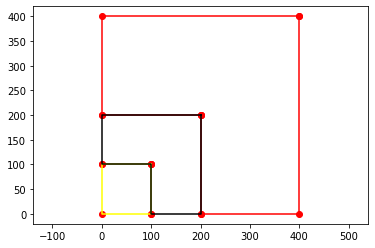

In [37]:
def plot_figs(*fgs, ax=None, color="blue"):
    plt.axis('equal')
    for f in fgs:
        xs, ys = list(), list()
        pts = list(f.exterior.coords)
        for x, y in pts:
            xs.append(x)
            ys.append(y)
        if ax is None:
            plt.plot(xs, ys, color=color)
            plt.scatter(xs, ys, color='red')
        else:
            ax.plot(xs, ys, color=color)
            ax.scatter(xs, ys, color='red')

def test_to_chunk_v2():
    scaling = 400
    shape_1 = Polygon([(0, 0), (0, 1.0 * scaling), (1.0 * scaling, 1.0 * scaling), (1.0 * scaling, 0), (0, 0)])
    shape_2 = Polygon([(0, 0), (0, 0.5 * scaling), (0.5 * scaling, 0.5 * scaling), (0.5* scaling, 0), (0, 0)])
    shape_3 = Polygon([(0, 0), (0, 0.25 * scaling), (0.25 * scaling, 0.25 * scaling), (0.25 * scaling, 0), (0, 0)])
    
    chunks = [ColorPoly(i, s, torch.tensor([i * 0.25, i* 0.25, i* 0.25, 1.0])) 
              for i, s in enumerate([shape_1, shape_2, shape_3])]
    carved_chunks = to_chunks_v3(chunks)
    
    print("\n".join([f"{cc.shape.wkt} {cc.color}" for cc in carved_chunks]))
    
    #fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for chunk, color in zip(carved_chunks, ["red", "blue", "green", "orange", "yellow", "black", "cyan"]):
        plot_figs(chunk.shape, color=color)
    #ColorPoly.render(chunks, axes[0, 0])
    #ColorPoly.render(carved_chunks[:1], axes[0, 1])
    #ColorPoly.render(carved_chunks[1:2], axes[1, 0])
    #ColorPoly.render(carved_chunks[2:3], axes[1, 1])
    
test_to_chunk_v2()

In [152]:
import pydiffvg
import bezier
from shapely.geometry import Polygon, Point, LineString, GeometryCollection, MultiPolygon, MultiLineString
from typing import NamedTuple, Tuple, List
from shapely.validation import make_valid
from collections import defaultdict
from copy import deepcopy
from rtree import index

    



def alpha_color_over(a, b):
    alpha_a, alpha_b = a[3], b[3]
    alpha_z = alpha_a + alpha_b * (1.0 - alpha_a)
    c_a, c_b = a[:3], b[:3]
    c_z = (c_a * alpha_a + c_b * alpha_b * (1.0 - alpha_a)) / alpha_z
    return torch.tensor((*c_z.numpy().tolist(), alpha_z))


def roundify(polygon, precision=5):
    pts = polygon.exterior.coords
    pts = list(map(lambda p: (round(p[0], precision), round(p[1], precision)), pts))
    return Polygon(pts)


def unroll_poly(s):
    polygons = list()
    try:
        for element in s.geoms:
            if element.is_empty or type(element) in [LineString, Point, MultiLineString] or element.area < 1.0:
                continue
            polygons.extend(unroll_poly(element))
    except AttributeError:
        simplified = s.buffer(-0.1).buffer(0.1)
        if type(simplified) in [MultiPolygon, GeometryCollection]:
            polygons.extend(unroll_poly(simplified))
        else:
            polygons.append(simplified)
    return polygons


def geom_cleaning(shape):
    if type(shape) in [Point, LineString, MultiLineString] or shape.area < 1:
        return Polygon()
    if type(shape) == GeometryCollection:
        polys = list(filter(lambda x: type(x) in [Polygon, MultiPolygon] and x.area > 0.5, shape.geoms))
        return GeometryCollection(polys)
    if not shape.is_valid:
        shape = make_valid(shape)
    shapes = list(filter(lambda x: type(x) == Polygon and x.area > 0.5, unroll_poly(shape)))
    if len(shapes) > 1:
        return MultiPolygon(shapes)
    elif len(shapes) == 0:
        return Polygon()
    else:
        return shapes[0]

    
class ColorPoly(NamedTuple):
    index: int
    shape: Polygon
    color: Tuple[int, int, int, int]
    depth: int = 0
        
    @classmethod
    def from_diffvg(cls, shapes, shape_groups):
        array = list()
        for s, sg in zip(shapes, shape_groups):
            pts = s.points.numpy().tolist()
            polys = geom_cleaning(make_valid(Polygon(pts + [pts[0]])))
            for p in unroll_poly(polys):
                array.append(cls(sg.shape_ids, p, sg.fill_color))
        return array
        
    @classmethod
    def to_chunks(cls, color_polys):
        chunks = list()
        
        for i in range(len(color_polygons)):
            a = color_polygons[i].shape
            current_intersections = list()
            
            # a - compute intersections with other polys
            for j in range(i + 1, len(color_polygons)):

                b = color_polygons[j].shape

                c = a.intersection(b)
                if c.is_empty or type(c) in [LineString, Point]:
                    continue
                blend = alpha_color_over(color_polys[i].color, color_polys[j].color)
                try:
                    for element in c.geoms:
                        new_element = ColorPoly(j+1, element, blend)
                        current_intersections.append(new_element)

                except AttributeError:
                    new_element = ColorPoly(j+1, c, blend)
                    current_intersections.append(new_element)

            chunks.extend(current_intersections)
            
            # b - add the main shape minus intersections
            remaining = a
            
            for intersection in current_intersections:
                remaining = remaining.difference(intersection.shape)
                
            try:
                for element in remaining.geoms:
                    if element.is_empty or type(element) in [LineString, Point]:
                        continue
                    chunks.append(ColorPoly(i, element, color_polygons[i].color))
            except AttributeError:
                chunks.append(ColorPoly(i, remaining, color_polygons[i].color))
        return chunks
    
    @classmethod
    def to_chunks_v2(cls, my_color_polys, max_depth=5):
        debug_index = -1
        done_index = set()
        def shape_update(poly, new_shape):
            if new_shape.area < 0.5:
                new_shape = Polygon()
            else:
                new_shape = geom_cleaning(new_shape)
            return cls(poly.index, new_shape, poly.color, poly.depth)
        my_chunks = deepcopy(my_color_polys)
        priority_queue = sorted(list(range(len(my_color_polys))), key=lambda i: my_color_polys[i].index)
        iter_ = 0
        print("total_blocks : ", len(my_chunks))

        while len(priority_queue) > 0:
            iter_ += 1
            #print("Queue size : ", len(priority_queue))
            i = priority_queue.pop()
            a = my_chunks[i].shape
            current_intersections = list()
            if my_chunks[i].depth > max_depth: # first order intersection only
                    continue
            if a.is_empty:
                continue
            #if my_chunks[i].color[3] < 0.01: # Layer is transparent
            #    continue
                
            if debug_index == my_chunks[i].index.numpy():
                print(f"i is {debug_index} : ", my_chunks[i].shape.area)

            current_intersections = list()
            for j in range(len(my_chunks)):
                if i == j:
                    continue
                if debug_index == my_chunks[j].index.numpy()[0]:
                    print(f"j is {debug_index} : ", my_chunks[j].shape.area)
                if (i, j) in done_index or (j, i) in done_index: #Intersection already processed
                    continue
                if j in done_index: # Higher up layer should been 100% done
                    continue
                if a.is_empty:
                    break
                cp = my_chunks[j]
                if cp.shape.is_empty:
                    continue
                #if my_chunks[j].color[3] < 0.01:
                #    continue
                try:
                    intersection = a.intersection(cp.shape)
                except Exception as e:
                    print("---> ", i, " ", j, " : ", my_chunks[i].shape, " ", my_chunks[j].shape)
                    raise e
                if intersection.is_empty or intersection.area < 0.5:
                    continue
                else:
                    if debug_index == my_chunks[j].index.numpy()[0]:
                        print(f"j intersection  is {debug_index} : ", intersection.area)
                        print(my_chunks[i].shape)
                        print(my_chunks[j].shape)
                    if debug_index == my_chunks[i].index.numpy()[0]:
                        print(f"i intersection  is {debug_index} : ", intersection.area)
                        print(my_chunks[i].shape)
                        print(my_chunks[j].shape)
                        print("\n")
                        
                    current_intersections.append(intersection)
                    #print(" ", intersection.area, " ----> ", intersection)
                    # Remove intersection from secondary poly
                    my_chunks[j] = shape_update(my_chunks[j], my_chunks[j].shape.difference(my_chunks[i].shape))
                    # Add intersection as a new chunk
                    new_index = len(my_chunks)
                    blend = alpha_color_over(my_chunks[i].color, my_chunks[j].color)
                    my_chunks.append(cls(my_chunks[i].index, geom_cleaning(intersection), 
                                         blend, my_chunks[i].depth + 1))
                    # This intersection will be the next items processed after the end of this loop
                    priority_queue.append(new_index)
                    done_index.add((new_index, j))
                    
            # Remove intersection from main poly
            if len(current_intersections) > 0:
                global_intersection = current_intersections[0]
                for intersection in current_intersections[1:]:
                    global_intersection = global_intersection.union(intersection)
                shape_minus_intersection = my_chunks[i].shape.difference(global_intersection)
                if debug_index == my_chunks[i].index.numpy()[0]:
                    print(f"global intersection of {i} : {global_intersection.wkt} \n\n")
                    print(f"remains of {i} : {shape_minus_intersection.wkt} \n\n")
                    print(f"final : {shape_update(my_chunks[i], shape_minus_intersection).shape.wkt}")
                my_chunks[i] = shape_update(my_chunks[i], shape_minus_intersection)
            done_index.add(i)


        return my_chunks
                    
    
    @classmethod
    def render(cls, color_polys, ax=None):
        shapes, shape_groups = list(), list()
        index = 0
        for cp in sorted(color_polys, key=lambda x: x.index):
            if cp.shape.is_empty or type(cp.shape) in [Point, LineString, MultiLineString]:
                continue
            polys = unroll_poly(cp.shape)
            for p in polys:
                s = pydiffvg.Polygon(points=torch.tensor(p.exterior.coords),
                                     stroke_width=torch.tensor(1.0), is_closed=True)
                shapes.append(s)
                sg = pydiffvg.ShapeGroup(shape_ids=torch.tensor([index]), fill_color=cp.color, 
                                         stroke_color=cp.color, use_even_odd_rule=False)
                shape_groups.append(sg)
                index += 1
            
        my_render(shapes, shape_groups, ax)

import copy
from rtree import index

def layer_carving_v2(new_chunks):
    elements = sorted(copy.deepcopy(new_chunks), key=lambda x: x.index.numpy()[0])

    my_index = index.Index()
    for i, e in enumerate(elements):
        if e.shape.is_empty:
            continue
        my_index.insert(e.index.numpy()[0], e.shape.bounds)

    for i in reversed(range(len(elements))):
        if elements[i].shape.is_empty:
            continue
        for j in my_index.intersection(elements[i].shape.bounds):
            if i == j:
                continue
            if elements[j].index < elements[i].index:
                current_shape = elements[j].shape
                elements[j] = ColorPoly(elements[j].index, 
                                        geom_cleaning(elements[j].shape.difference(elements[i].shape)), 
                                        elements[j].color)

    new_new_chunks = list()        
    for chunk in elements:
        new_polys = unroll_poly(chunk.shape)
        new_new_chunks.extend([ColorPoly(chunk.index, s, chunk.color) for s in new_polys])
        
    return new_new_chunks

def self_intersection_area(elements):
    from rtree import index
    total_area = 0
    my_index = index.Index()
    for i, e in enumerate(elements):
        if e.shape.is_empty:
            continue
        my_index.insert(i, e.shape.bounds)
        
    for current_index, e in enumerate(elements):
        if e.shape.is_empty:
            continue
        possibles_intersections = my_index.intersection(e.shape.bounds)
        
        for i in possibles_intersections:
            if i == current_index:
                continue
            total_area += e.shape.intersection(elements[i].shape).area
            
    return total_area / 2

In [129]:
color_polygons_ = ColorPoly.from_diffvg(shapes, shape_groups)

In [149]:
import time

tt = time.time()
rez = ColorPoly.to_chunks_v2(color_polygons_, max_depth=10)
print(time.time() - tt)
total_self_interaction = self_intersection_area(rez)
print(i, total_self_interaction)

total_blocks :  394
301.78231835365295
2 19.50011508104438


In [151]:
len(rez)

11166

0.0

Text(0.5, 1.0, 'render')

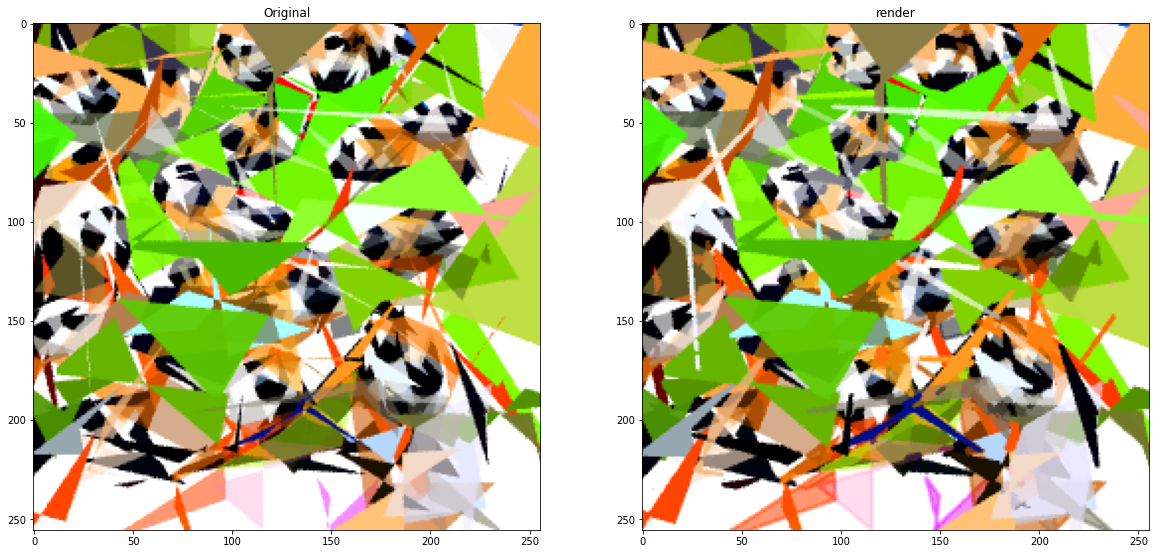

In [141]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 20))

my_render(shapes, shape_groups, axes[0])
axes[0].set_title("Original")
ColorPoly.render([r for r in rez if torch.isfinite(torch.sum(r.color))], ax=axes[1])
axes[1].set_title("render")
#carved_chunks = layer_carving(rez)
#ColorPoly.render([r for r in carved_chunks if torch.isfinite(torch.sum(r.color))], ax=axes[2])
#axes[2].set_title("carved")

In [153]:

results = layer_carving_v2(rez)

Text(0.5, 1.0, 'render')

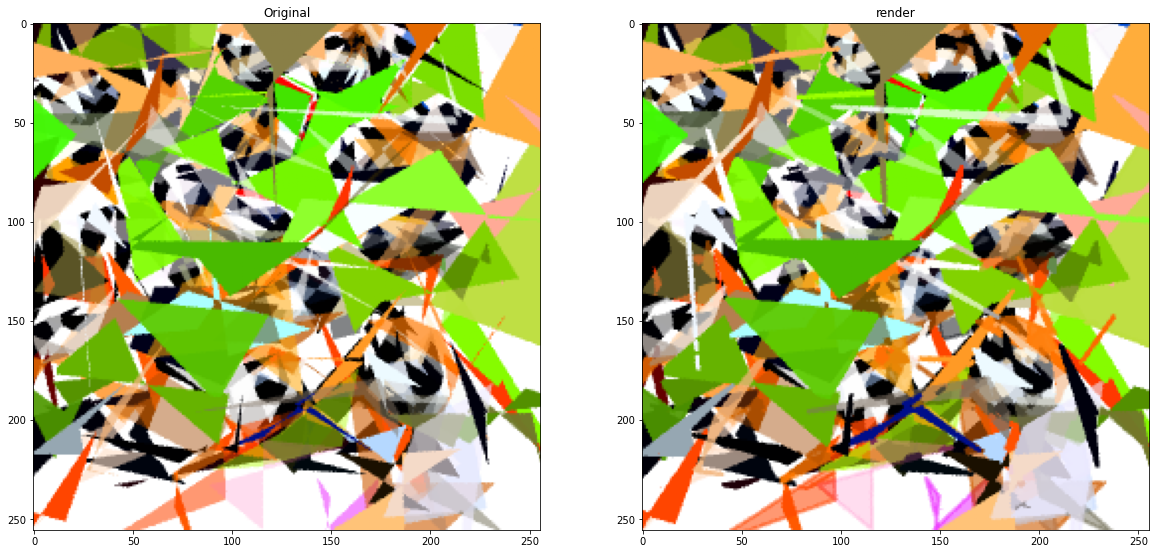

In [154]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

my_render(shapes, shape_groups, axes[0])
axes[0].set_title("Original")
ColorPoly.render([r for r in results if torch.isfinite(torch.sum(r.color))], ax=axes[1])
axes[1].set_title("render")

In [155]:
chunks = [r for r in results if torch.isfinite(torch.sum(r.color))]

X = [rgb2lab(
    c.color.numpy()[:3] * c.color.numpy()[3] + (0.8 * np.array([1.0, 1.0, 1.0]) * (1.0 - c.color.numpy()[3])))
    for c in chunks]
W = [c.shape.area for c in chunks]

kmeans = KMeans(n_clusters=5, random_state=0, max_iter=1000)
kmeans.fit(X, sample_weight=W)
assigned_colors = kmeans.predict(X)

new_chunks = [ColorPoly(
    c.index, c.shape,
    torch.tensor((*lab2rgb(kmeans.cluster_centers_[assigned_colors[i]]).tolist(), 1.0))) for i, c in
    enumerate(chunks)]

Text(0.5, 1.0, 'render')

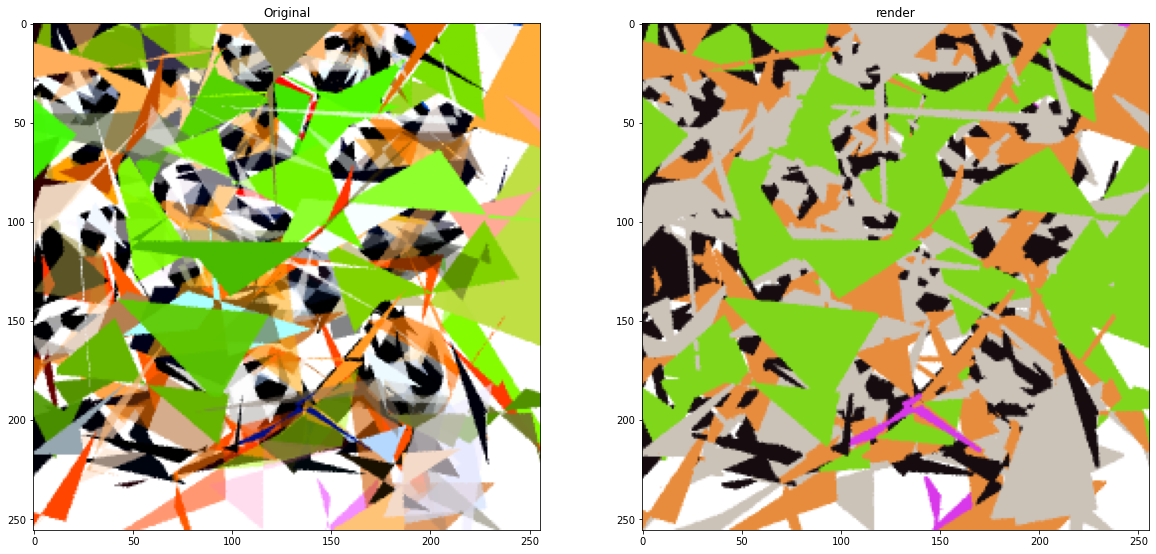

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

my_render(shapes, shape_groups, axes[0])
axes[0].set_title("Original")
ColorPoly.render([r for r in new_chunks if torch.isfinite(torch.sum(r.color))], ax=axes[1])
axes[1].set_title("render")


2541 2541 2541
4 613
0 61
1 459
3 906
2 502


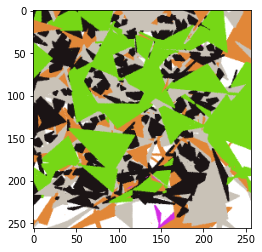

In [66]:
from collections import defaultdict

n_color = 5
print(len(new_chunks), len(chunks), len(assigned_colors))

color_layer = defaultdict(list)
for i, c_index in enumerate(assigned_colors):
    color_layer[c_index].append(i)

total_shapes = dict()

for color_index, indices in color_layer.items():
    print(color_index, len(indices))
    max_index = max(new_chunks[i].index for i in indices)
    total = new_chunks[indices[0]].shape
    for i in indices[1:]:
        blob = new_chunks[i].shape
        total = total.union(blob)
    total_shapes[color_index] = ColorPoly(max_index, total, new_chunks[indices[0]].color)

ColorPoly.render(list(total_shapes.values()))

Text(0.5, 1.0, 'render')

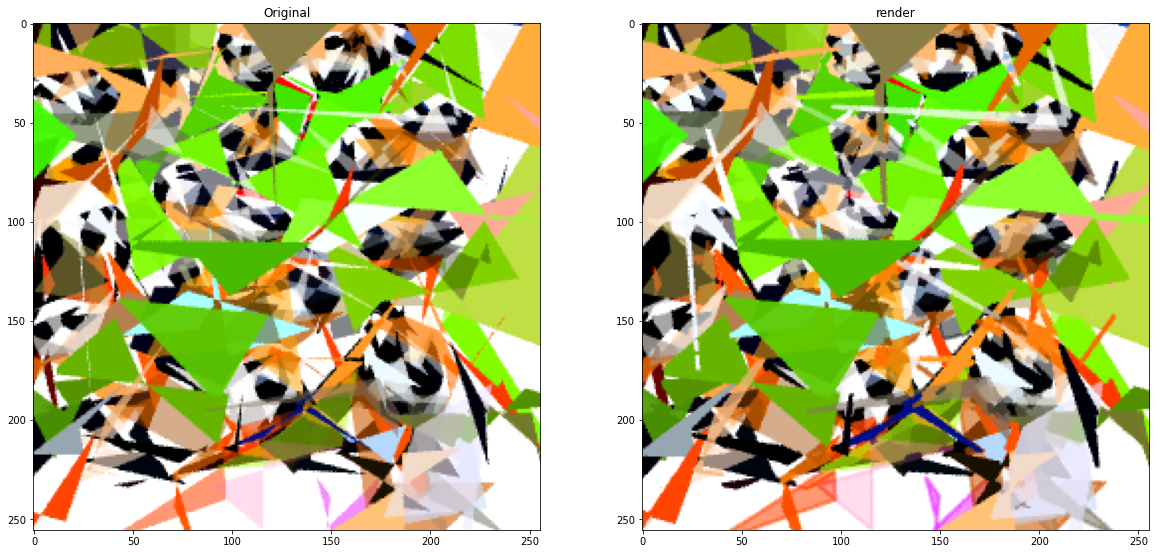

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

my_render(shapes, shape_groups, axes[0])
axes[0].set_title("Original")
ColorPoly.render([r for r in results if torch.isfinite(torch.sum(r.color))], ax=axes[1])
axes[1].set_title("render")



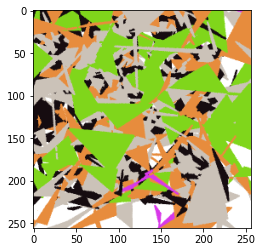

In [137]:
ColorPoly.render(new_chunks)

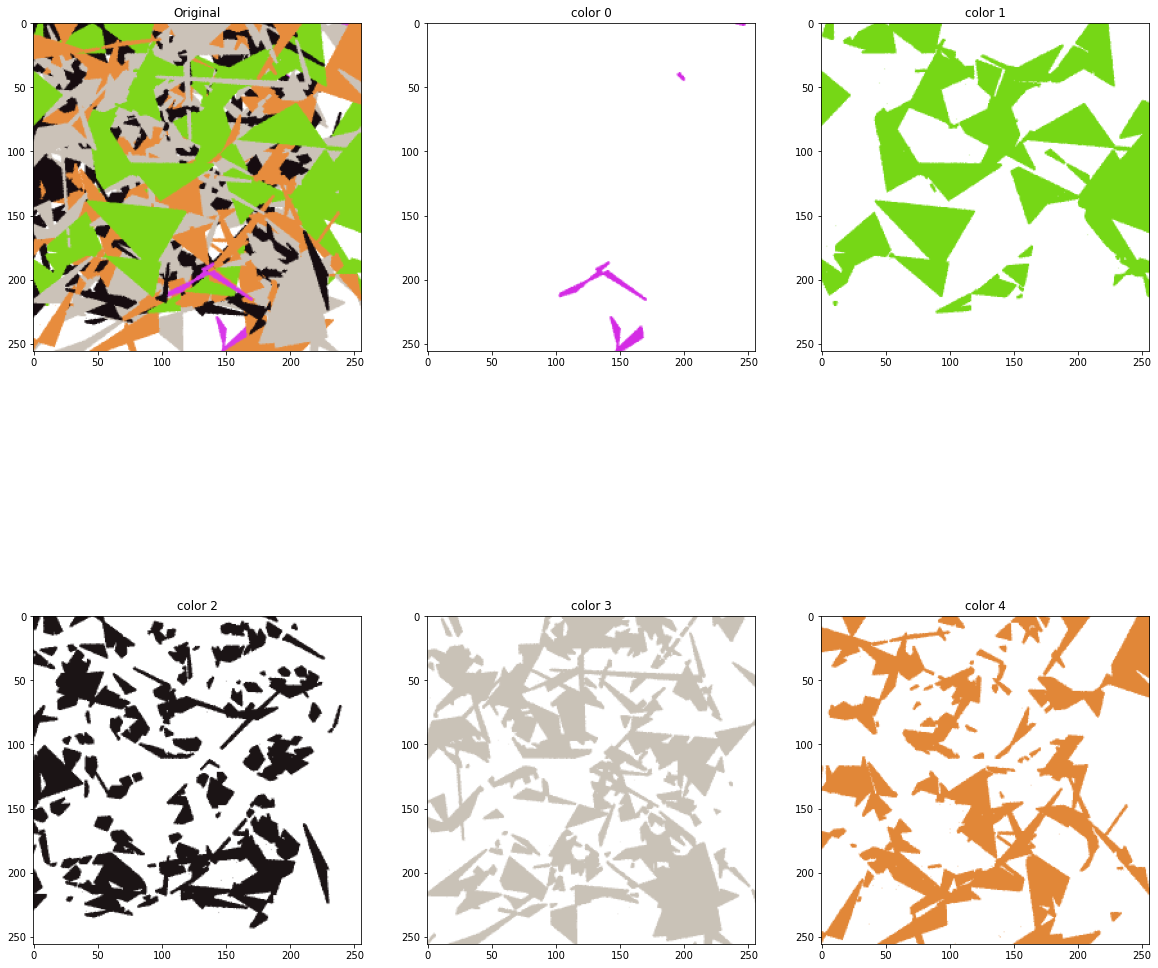

In [138]:
fig, axes = plt.subplots(2, 3, figsize=(20, 20))

ColorPoly.render(new_chunks, ax=axes[0, 0])
axes[0, 0].set_title("Original")
for i in total_shapes:
    k = i + 1
    ColorPoly.render([total_shapes[i]], ax=axes[int(k / 3), k % 3])
    axes[int(k / 3), k % 3].set_title(f"color {i}")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

index = 190

a = [cp for cp in color_polygons_ if cp.index.numpy()[0] == index]
b = [cp for cp in rez if cp.index.numpy()[0] == index]

ColorPoly.render(a, ax=axes[0])
axes[0].set_title("Original")
ColorPoly.render(b, ax=axes[1])
axes[1].set_title("render")